In [231]:
#Python version
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [232]:
#Install uninstalled modules, comment if it's already installed

'''
!pip install tensorflow==1.15
!pip install finta
!pip install stable-baselines
!pip install MetaTrader5
!pip install gym
!pip install gym-anytrading
!pip install quantstats
'''

'\n!pip install tensorflow==1.15\n!pip install finta\n!pip install stable-baselines\n!pip install MetaTrader5\n!pip install gym\n!pip install gym-anytrading\n!pip install quantstats\n'

In [233]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.callbacks import EvalCallback

import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

import datetime, os, pytz
import MetaTrader5 as mt5

In [234]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,              # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 authorized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 cant authorize, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!
Metatrader5 authorized!

 account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
19    

In [236]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0


In [237]:
Symbol = "EURUSD"
Timeframe = mt5.TIMEFRAME_M5
symbol_info = mt5.symbol_info(Symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    print(symbol_info)
    print("\n","EURJPY: spread =",symbol_info.spread,"  digits =",symbol_info.digits, "\n")
    # Extract symbol info
    
    print(symbol_info[3])

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1623300484, digits=5, spread=10, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, ...)

 EURJPY: spread = 10   digits = 5 

True


In [238]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
# create 'datetime' object in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime.datetime(2020, 1, 10, tzinfo=timezone)

# getbars from the current day
bar = 4000
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/{}.csv'.format(Symbol), index=False)
pd.read_csv('./Datasets/{}.csv'.format(Symbol))


Display dataframe with data
                    time     open     high      low    close  tick_volume  \
0    2021-05-21 06:00:00  1.22334  1.22335  1.22314  1.22323        148.0   
1    2021-05-21 06:05:00  1.22323  1.22330  1.22310  1.22312        113.0   
2    2021-05-21 06:10:00  1.22312  1.22321  1.22310  1.22312        104.0   
3    2021-05-21 06:15:00  1.22312  1.22335  1.22310  1.22328        132.0   
4    2021-05-21 06:20:00  1.22327  1.22342  1.22323  1.22336         98.0   
...                  ...      ...      ...      ...      ...          ...   
3995 2021-06-10 04:25:00  1.21720  1.21727  1.21714  1.21726        138.0   
3996 2021-06-10 04:30:00  1.21724  1.21748  1.21721  1.21745        151.0   
3997 2021-06-10 04:35:00  1.21744  1.21760  1.21733  1.21739        205.0   
3998 2021-06-10 04:40:00  1.21739  1.21742  1.21725  1.21727        100.0   
3999 2021-06-10 04:45:00  1.21730  1.21730  1.21710  1.21710         95.0   

      spread  real_volume  
0        9.0      

,time,open,high,low,close,tick_volume,spread,real_volume
0,2021-05-21 06:00:00,1.22334,1.22335,1.22314,1.22323,148.0,9.0,0.0
1,2021-05-21 06:05:00,1.22323,1.22330,1.22310,1.22312,113.0,9.0,0.0
2,2021-05-21 06:10:00,1.22312,1.22321,1.22310,1.22312,104.0,9.0,0.0
3,2021-05-21 06:15:00,1.22312,1.22335,1.22310,1.22328,132.0,10.0,0.0
4,2021-05-21 06:20:00,1.22327,1.22342,1.22323,1.22336,98.0,9.0,0.0
...,...,...,...,...,...,...,...,...
3995,2021-06-10 04:25:00,1.21720,1.21727,1.21714,1.21726,138.0,9.0,0.0
3996,2021-06-10 04:30:00,1.21724,1.21748,1.21721,1.21745,151.0,9.0,0.0
3997,2021-06-10 04:35:00,1.21744,1.21760,1.21733,1.21739,205.0,8.0,0.0
3998,2021-06-10 04:40:00,1.21739,1.21742,1.21725,1.21727,100.0,8.0,0.0


In [239]:
# read csv from datasets folder
df = pd.read_csv('./Datasets/{}.csv'.format(Symbol))

# turn time coloumn into datetime
df['time'] = pd.to_datetime(df['time'])

del df['real_volume']

# make indicator coloumns to the dataframe
df['EMA'] = TA.EMA(df, 100, 'open')
df['RSI'] = TA.RSI(df, 14, 'open')
df['ATR'] = TA.ATR(df, 14)
df.fillna(0, inplace=True)

#  rename coloumn's name
df = df.rename(columns={
    "time":"Date",
    "open":"Open",
    "high":"High",
    "low":"Low",
    "close":"Close",
    "tick_volume":"Tick_volume",
    "spread":"Spread",
})

df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Tick_volume,Spread,EMA,RSI,ATR
Date,,,,,,,,,
2021-05-21 06:00:00,1.22334,1.22335,1.22314,1.22323,148.0,9.0,1.223340,0.000000,0.000000
2021-05-21 06:05:00,1.22323,1.22330,1.22310,1.22312,113.0,9.0,1.223284,0.000000,0.000000
2021-05-21 06:10:00,1.22312,1.22321,1.22310,1.22312,104.0,9.0,1.223229,0.000000,0.000000
2021-05-21 06:15:00,1.22312,1.22335,1.22310,1.22328,132.0,10.0,1.223201,0.000000,0.000000
2021-05-21 06:20:00,1.22327,1.22342,1.22323,1.22336,98.0,9.0,1.223215,45.055992,0.000000
...,...,...,...,...,...,...,...,...,...
2021-06-10 04:25:00,1.21720,1.21727,1.21714,1.21726,138.0,9.0,1.217928,30.515828,0.000216
2021-06-10 04:30:00,1.21724,1.21748,1.21721,1.21745,151.0,9.0,1.217915,33.033477,0.000223
2021-06-10 04:35:00,1.21744,1.21760,1.21733,1.21739,205.0,8.0,1.217905,43.965898,0.000236


In [240]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Open'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'EMA', 'RSI', 'ATR']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(ForexEnv):
    _process_data = add_signals


env information:
> shape: (10, 4)
> df.shape: (4000, 9)
> prices.shape: (4000,)
> signal_features.shape: (4000, 4)
> max_possible_profit: 1.0011509965966863


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 4), float32)


> signal features:  [[1.22334000e+00 1.22334000e+00 0.00000000e+00 0.00000000e+00]
 [1.22323000e+00 1.22328445e+00 0.00000000e+00 0.00000000e+00]
 [1.22312000e+00 1.22322853e+00 0.00000000e+00 0.00000000e+00]
 ...
 [1.21744000e+00 1.21790515e+00 4.39658982e+01 2.36428571e-04]
 [1.21739000e+00 1.21789495e+00 4.21148466e+01 2.35714286e-04]
 [1.21730000e+00 1.21788317e+00 3.89370723e+01 2.31428571e-04]]


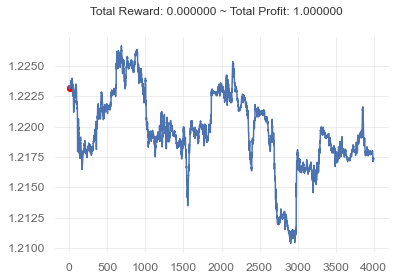

In [241]:
window_size = 10
start_index = window_size
end_index = len(df)
env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()


In [242]:
print(env.df)
print("\n")
env.df.info()

                        Open     High      Low    Close  Tick_volume  Spread  \
Date                                                                           
2021-05-21 06:00:00  1.22334  1.22335  1.22314  1.22323        148.0     9.0   
2021-05-21 06:05:00  1.22323  1.22330  1.22310  1.22312        113.0     9.0   
2021-05-21 06:10:00  1.22312  1.22321  1.22310  1.22312        104.0     9.0   
2021-05-21 06:15:00  1.22312  1.22335  1.22310  1.22328        132.0    10.0   
2021-05-21 06:20:00  1.22327  1.22342  1.22323  1.22336         98.0     9.0   
...                      ...      ...      ...      ...          ...     ...   
2021-06-10 04:25:00  1.21720  1.21727  1.21714  1.21726        138.0     9.0   
2021-06-10 04:30:00  1.21724  1.21748  1.21721  1.21745        151.0     9.0   
2021-06-10 04:35:00  1.21744  1.21760  1.21733  1.21739        205.0     8.0   
2021-06-10 04:40:00  1.21739  1.21742  1.21725  1.21727        100.0     8.0   
2021-06-10 04:45:00  1.21730  1.21730  1

info: {'total_reward': -52.30000000007182, 'total_profit': 0.7763606583416586, 'position': 1}


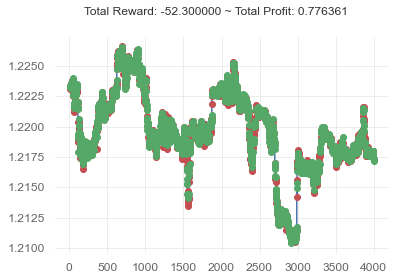

Date
2021-05-21 06:25:00    0.000000
2021-05-21 06:30:00   -0.000213
2021-05-21 06:35:00    0.000000
2021-05-21 06:40:00    0.000000
2021-05-21 06:45:00    0.000000
                         ...   
2021-06-10 03:50:00    0.000000
2021-06-10 03:55:00    0.000000
2021-06-10 04:00:00   -0.000509
2021-06-10 04:05:00    0.000000
2021-06-10 04:10:00   -0.000066
Length: 3988, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2021-05-21
End Period                 2021-06-10
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -22.36%
CAGR%                      -99.23%

Sharpe                     -5.98
Sortino                    -5.82
Sortino/√2                 -4.12

Max Drawdown               -22.36%
Longest DD Days            19
Volatility (ann.)          0.27%
Calmar                     -4.44
Skew                       -2.36
Kurtosis                   18.94

Expected Daily %           -0.01%
Expected Monthly %         -11.89%
Expected Yearly %          -22.36%
Kelly Criterion            -129.99%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.03%
Expected Shortfall (cVaR)  -0.03%

Gain/Pain Ratio            -1.0
Gain/Pain (1M)             -1.0

Payoff Ratio               0.63
Profit Factor              0.08
Common Sense Ratio         0.0
CPC Index     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-21,2021-06-10,2021-06-10,19,-22.363934,-22.135975


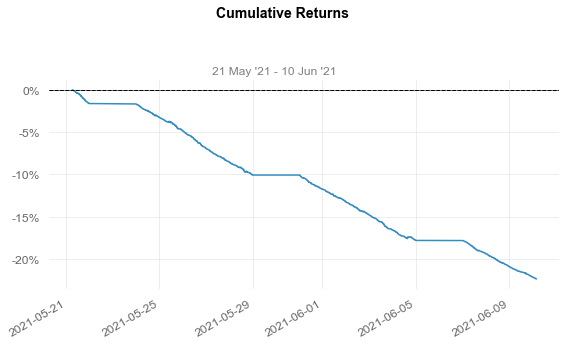

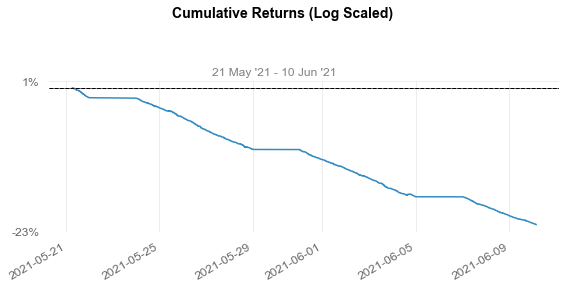

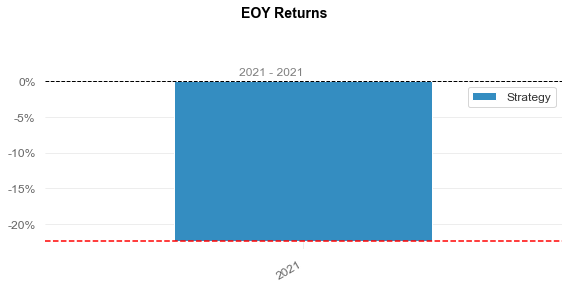

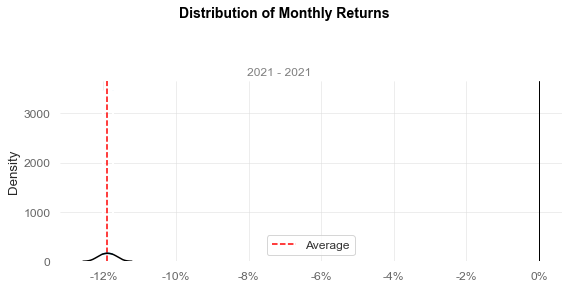

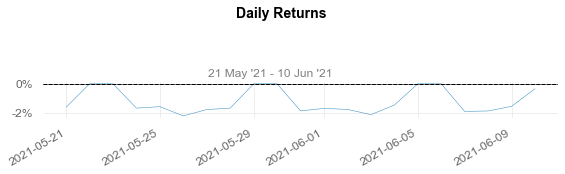

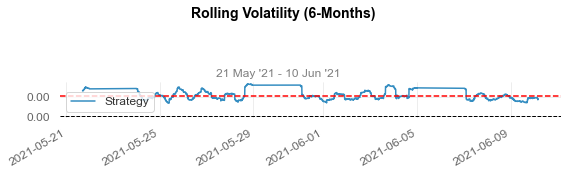

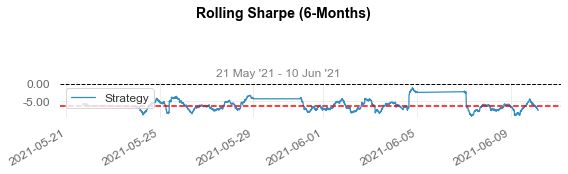

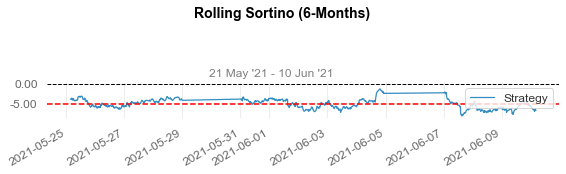

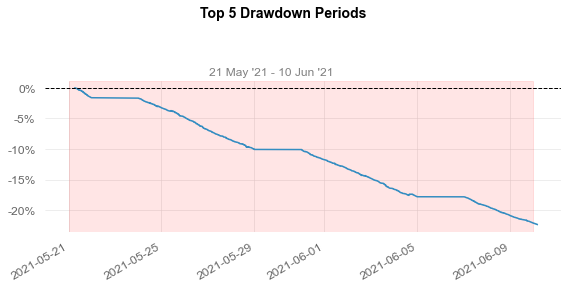

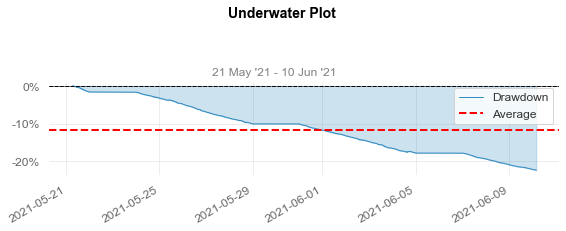

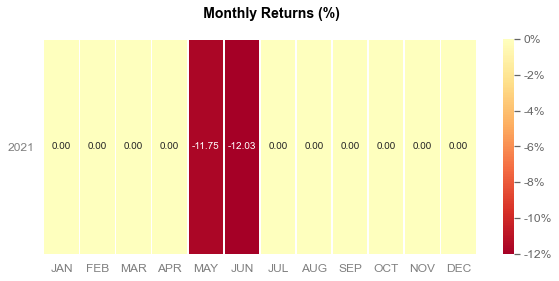

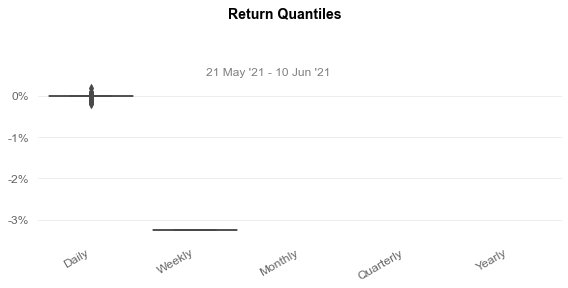

In [235]:
# Based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Random Result/random quantstats.html'.format(Symbol, Timeframe))

In [202]:
env_maker = lambda: env
env = DummyVecEnv([env_maker])

eval_callback = EvalCallback(env, best_model_save_path='./Saved_Model/{}-{}-Model'.format(Symbol, Timeframe),
                             log_path='./logs/{}_{}'.format(Symbol, Timeframe), eval_freq=500,
                             deterministic=True, render=False)
timesteps = 1000000

policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs) 
model.learn(total_timesteps=timesteps, callback=eval_callback)

300    |
| policy_entropy     | 0.000141 |
| total_timesteps    | 441500   |
| value_loss         | 8.14e-11 |
---------------------------------
Eval num_timesteps=442000, episode_reward=0.40 +/- 0.00
Episode length: 3989.00 +/- 0.00
---------------------------------
| explained_variance | -0.0091  |
| fps                | 28       |
| nupdates           | 88400    |
| policy_entropy     | 0.000142 |
| total_timesteps    | 442000   |
| value_loss         | 8.5e-11  |
---------------------------------
Eval num_timesteps=442500, episode_reward=0.40 +/- 0.00
Episode length: 3989.00 +/- 0.00
---------------------------------
| explained_variance | -0.0156  |
| fps                | 28       |
| nupdates           | 88500    |
| policy_entropy     | 0.000142 |
| total_timesteps    | 442500   |
| value_loss         | 8.61e-11 |
---------------------------------
Eval num_timesteps=443000, episode_reward=0.40 +/- 0.00
Episode length: 3989.00 +/- 0.00
---------------------------------
| explaine

KeyboardInterrupt: 

In [227]:
#del model # remove to demonstrate saving and loading

#model = A2C.load('./Saved_Model/{}-{}-Model'.format(Symbol, Timeframe))
model = A2C.load('D:\TugasKampus\Fun Project\MT5_TensorDL\Saved_Model\EURUSD-5-Model\model.zip')

env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info: {'total_reward': -42.900000000016796, 'total_profit': 0.9853391447583876, 'position': 1}


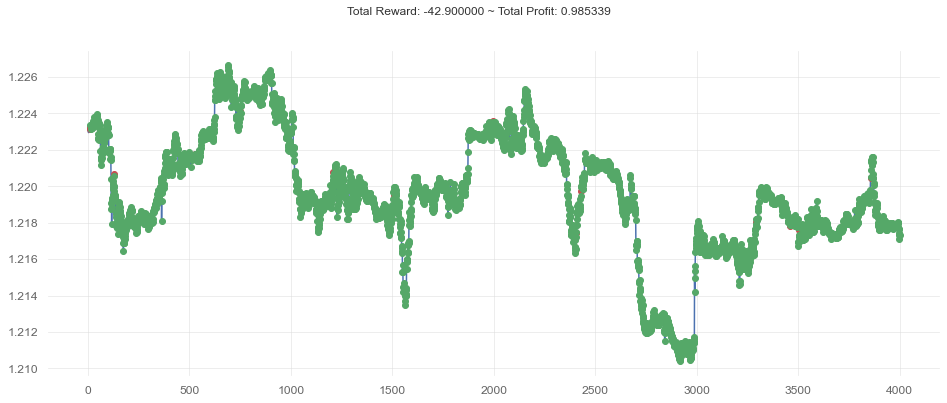

In [228]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

Date
2021-05-21 06:25:00    0.000000
2021-05-21 06:30:00   -0.000278
2021-05-21 06:35:00    0.000000
2021-05-21 06:40:00    0.000000
2021-05-21 06:45:00    0.000000
                         ...   
2021-06-10 03:50:00    0.000000
2021-06-10 03:55:00    0.000000
2021-06-10 04:00:00    0.000000
2021-06-10 04:05:00    0.000000
2021-06-10 04:10:00   -0.002835
Length: 3988, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2021-05-21
End Period                 2021-06-10
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          -1.47%
CAGR%                      -24.7%

Sharpe                     -0.3
Sortino                    -0.34
Sortino/√2                 -0.24

Max Drawdown               -1.59%
Longest DD Days            19
Volatility (ann.)          0.31%
Calmar                     -15.51
Skew                       -16.23
Kurtosis                   655.36

Expected Daily %           -0.0%
Expected Monthly %         -0.74%
Expected Yearly %          -1.47%
Kelly Criterion            -36.55%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.03%
Expected Shortfall (cVaR)  -0.03%

Gain/Pain Ratio            -0.56
Gain/Pain (1M)             -1.0

Payoff Ratio               0.68
Profit Factor              0.55
Common Sense Ratio         nan
CPC Index          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-05-21,2021-06-04,2021-06-10,19,-1.592821,-1.470923


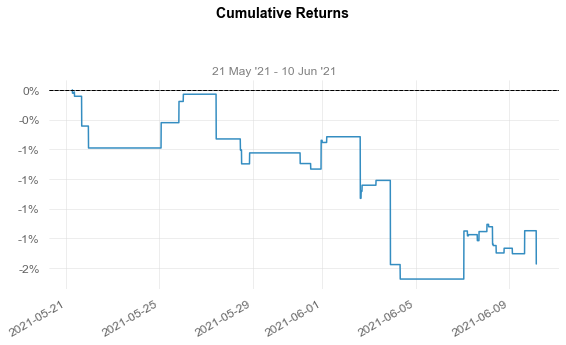

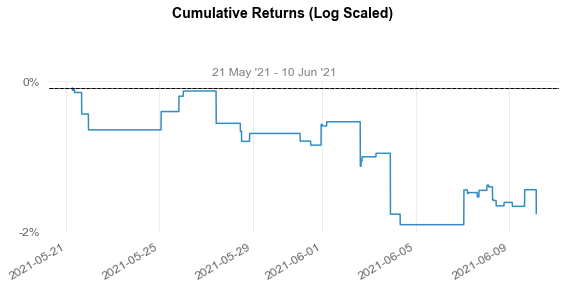

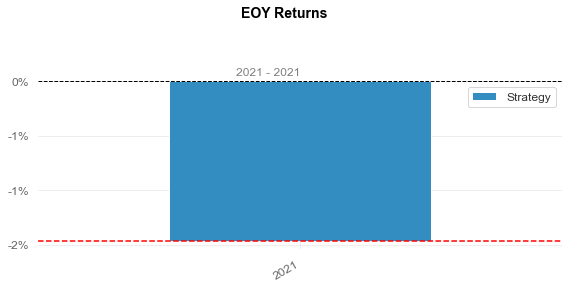

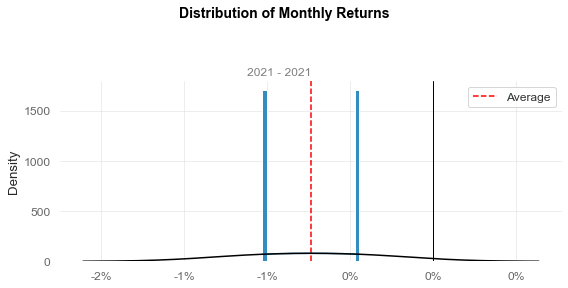

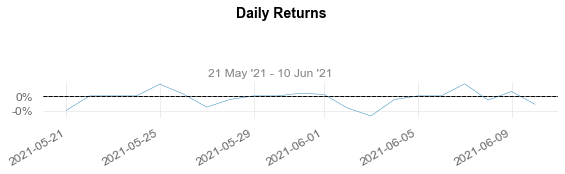

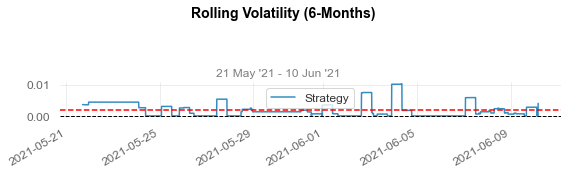

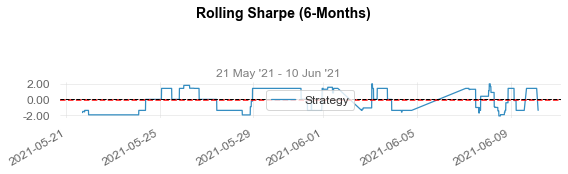

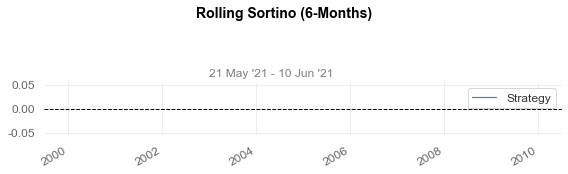

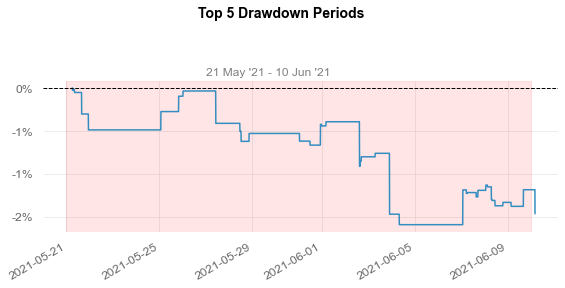

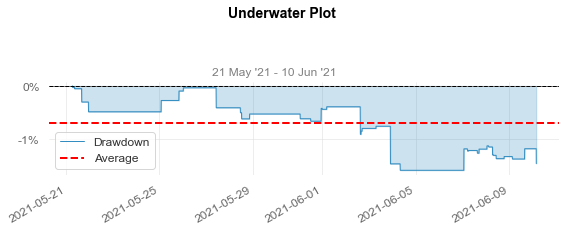

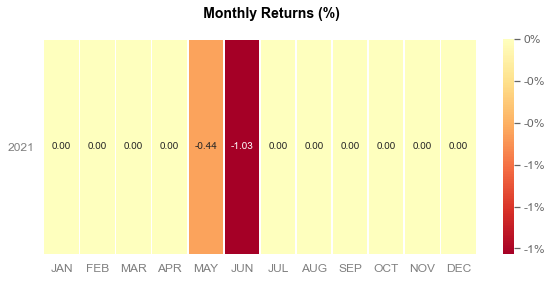

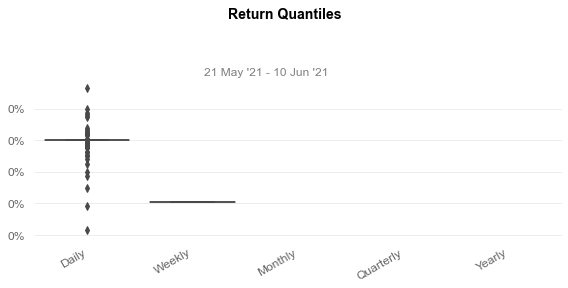

In [230]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Backtesting/{}_{}_quantstats.html'.format(Symbol, Timeframe))
